In [34]:
from pandas import *
import sys
path = '/Users/jplotkin/Dropbox/school/adv_ml'
path += '/project/scripts_notebooks'
sys.path.append(path)

from prep_datasets import *
from train_cv_predict import *
plt.style.use('ggplot')

%load_ext autotime
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 79.7 ms


### Load data
* image features from CNN
* metadata

In [2]:
data_path = '../boots_dataset/'
metadata_women = read_csv(data_path + 'boots_aws_metadata_160405.csv',
                         index_col = 'asin')
metadata_women = metadata_women[metadata_women.sex == 'women']
features_women = read_csv(data_path + 'features_women.csv',
                         index_col = 'asin')

time: 3.56 s


In [3]:
path = '/Users/jplotkin/Dropbox/school/adv_ml/'
path += 'project/ImageRec/data/test_likes.txt'
likes_dislikes = read_csv(path, 
                 header = None)\
                    .drop_duplicates()\
                    .set_index(0, inplace = False)
likes_dislikes.index.name = 'asin'
likes_dislikes.columns = ['like']

time: 27.9 ms


In [4]:
likes_dislikes.merge(metadata_women, left_index = True, 
                    right_index = True).merge(features_women, left_index = True, 
                           right_index = True).like.value_counts()

0    142
1      4
Name: like, dtype: int64

time: 46.8 ms


In [5]:
likes = likes_dislikes.merge(metadata_women, left_index = True, 
                    right_index = True).merge(features_women, left_index = True, 
                           right_index = True).like

time: 41.2 ms


### PrepData class
* balance dataset by oversampling
* perform stratified sampling to split data
* takes list of size of training set (the rest go into test)
* creates a feature set of unlabeled data (for recommendations)

In [6]:
dataset = PrepData(DataFrame(likes), features_women, 
                   [10, 25, 50, 80], 5, False)

10 0.931506849315
10 136
10 136
10 136
10 136
10 136
25 0.828767123288
25 121
25 121
25 121
25 121
25 121
50 0.657534246575
50 96
50 96
50 96
50 96
50 96
80 0.452054794521
80 66
80 66
80 66
80 66
80 66
time: 22.2 s


In [7]:
print dataset.training_sets.keys()
print dataset.test_sets.keys()

[80, 25, 10, 50]
[80, 25, 10, 50]
time: 34.4 ms


In [8]:
dataset.training_sets[50][0].like.value_counts()

0    49
1     1
Name: like, dtype: int64

time: 29.5 ms


In [9]:
dataset.training_sets[50][0].drop_duplicates().like.value_counts()

0    49
1     1
Name: like, dtype: int64

time: 280 ms


In [10]:
dataset.test_sets[50][0].like.value_counts()

0    93
1     3
Name: like, dtype: int64

time: 29.3 ms


In [11]:
dataset.test_sets[50][0].drop_duplicates().like.value_counts()

0    93
1     3
Name: like, dtype: int64

time: 275 ms


In [12]:
asin_in = []
for asin in dataset.test_sets[50][0].index:
    asin_in.append(asin in dataset.training_sets[50][0])
print sum(asin_in)

0
time: 28.2 ms


### TrainModel class
TrainModel(train, test, algo, grid params, nfolds)
* performs grid search automatically using params and number of folds
* returns best model
* include methods to get AUC, plot ROC, and show top n recommendations
* TODO: implement XGBoost grid search 

In [13]:
training_set = dataset.training_sets[80][3]
test_set = dataset.test_sets[80][3]
unlabeled = dataset.unlabeled

time: 30.5 ms


In [14]:
training_set.like.value_counts()

0    78
1     2
Name: like, dtype: int64

time: 30.9 ms


In [15]:
test_set.like.value_counts()

0    64
1     2
Name: like, dtype: int64

time: 40.7 ms


### XGBoost:

In [16]:
# num_round=2

# def fpreproc(dtrain, dtest, param):
#     label = dtrain.get_label()
#     ratio = float(np.sum(label == 0)) / np.sum(label==1)
#     param['scale_pos_weight'] = ratio
#     return (dtrain, dtest, param)


# xgb.cv(param, training_set.copy(), num_round, nfold=5,
#        metrics={'auc'}, seed = 0, fpreproc = fpreproc)

time: 34.1 ms


[0]	train-auc:0.987179
[1]	train-auc:1.000000
[2]	train-auc:1.000000
[3]	train-auc:1.000000
[4]	train-auc:1.000000
[5]	train-auc:1.000000
[6]	train-auc:1.000000
[7]	train-auc:1.000000
[8]	train-auc:1.000000
[9]	train-auc:1.000000


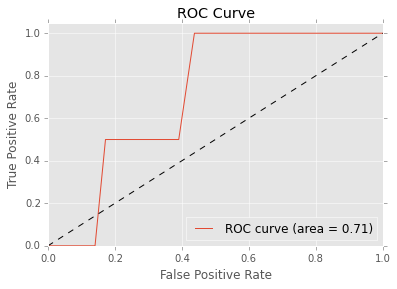

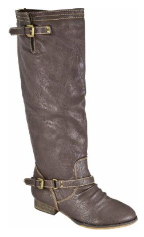

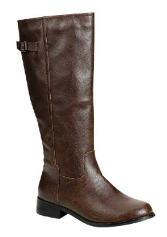

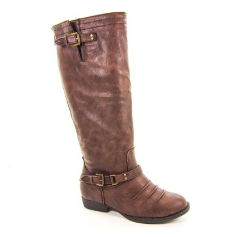

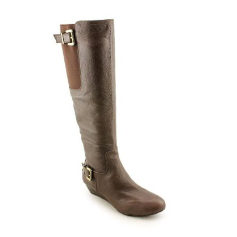

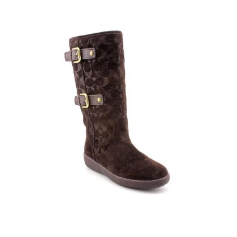

time: 2.08 s


In [36]:
param = {'bst:max_depth':2, 
         'bst:eta':1, 
         'silent':1,
         'objective':'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
param['eval_metric'] = ['auc']
model = TrainModel(training_set.copy(), test_set.copy(), 
                   'xgb_no_cv', param, 5)
model.get_auc()
model.plot_roc()
model.display_recommendations(unlabeled.copy(), 5)

### SVM:

0.5
Model with rank: 1
Mean validation score: 0.975 (std: 0.029)
Parameters: {'kernel': 'linear', 'C': 9.9999999999999995e-08}

Model with rank: 2
Mean validation score: 0.975 (std: 0.029)
Parameters: {'kernel': 'linear', 'C': 1.2589254117941662e-07}

Model with rank: 3
Mean validation score: 0.975 (std: 0.029)
Parameters: {'kernel': 'linear', 'C': 1.5848931924611109e-07}



/Users/jplotkin/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


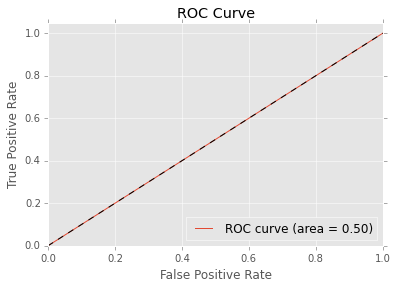

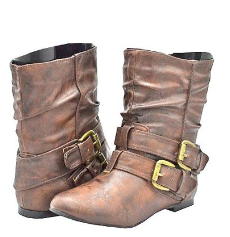

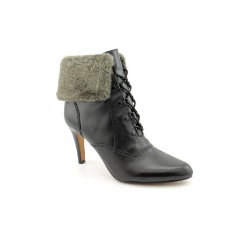

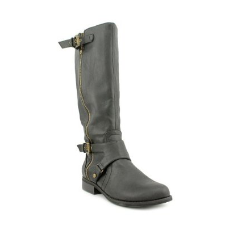

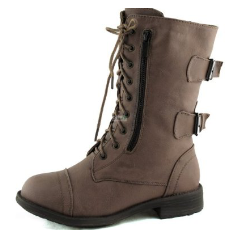

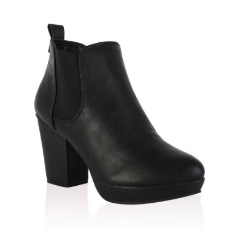

time: 49 s


In [18]:
param_grid = [
  {'C': [10**i for i in np.arange(-7,2,.1)], 
       'kernel': ['linear'], 
       'class_weight': [{1: 0.75, 0: 0.25}, {1: 0.90, 0: 0.10}, {1: 0.50, 0: 0.50}]
},
  {'C': [10**i for i in np.arange(-7,2,.1)], 
       'gamma': [0.001, 0.0001], 'kernel': ['rbf'],
       'class_weight': [{1: 0.75, 0: 0.25}, {1: 0.90, 0: 0.10}, {1: 0.50, 0: 0.50}]
},
 ]
svm = TrainModel(training_set.copy(), test_set.copy(), 
                   'svm', param_grid, 10)

print svm.get_auc()
svm.report()
svm.plot_roc()

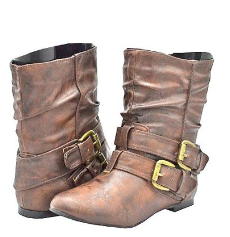

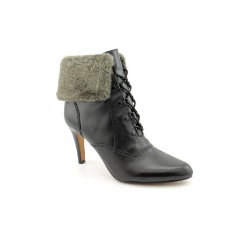

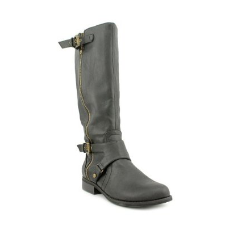

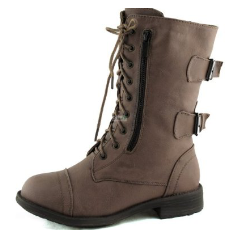

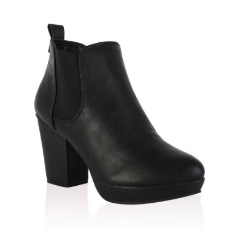

time: 660 ms


In [24]:
svm.model.fit(training_set.drop('like', axis = 1), training_set.like)
svm.display_recommendations(unlabeled.copy(), 10)

### Naive Bayes

Model with rank: 1
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 9.9999999999999995e-08}

Model with rank: 2
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 1.2589254117941662e-07}

Model with rank: 3
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 1.5848931924611109e-07}



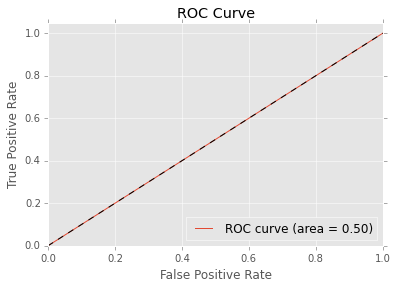

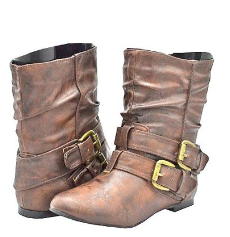

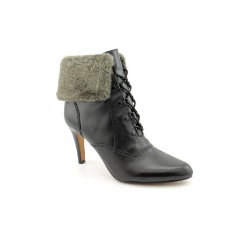

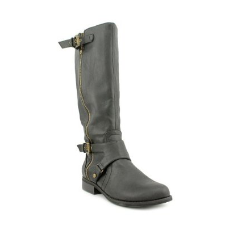

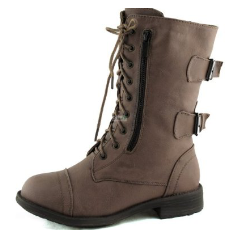

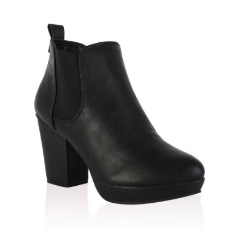

time: 6.08 s


In [19]:
param_grid = [
  {'alpha': [10**i for i in np.arange(-7,2,.1)]}
 ]    
nb = TrainModel(training_set.copy(), test_set.copy(),
                   'nb', param_grid, 10)
nb.get_auc()
nb.report()
nb.plot_roc()

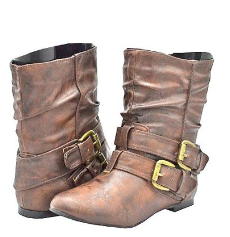

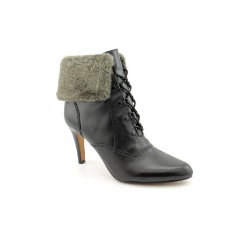

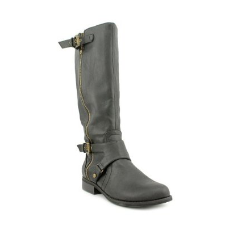

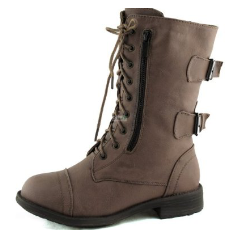

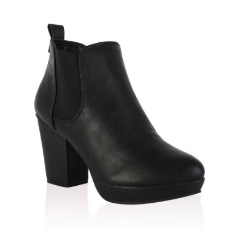

time: 544 ms


In [25]:
nb.model.fit(training_set.drop('like', axis = 1), training_set.like)
nb.display_recommendations(unlabeled.copy(), 10)

### Random Forest

Model with rank: 1
Mean validation score: 0.975 (std: 0.029)
Parameters: {'bootstrap': True, 'min_samples_leaf': 100, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 1, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.975 (std: 0.029)
Parameters: {'bootstrap': True, 'min_samples_leaf': 100, 'min_samples_split': 101, 'criterion': 'gini', 'max_features': 1, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.975 (std: 0.029)
Parameters: {'bootstrap': True, 'min_samples_leaf': 100, 'min_samples_split': 201, 'criterion': 'gini', 'max_features': 1, 'max_depth': 3}



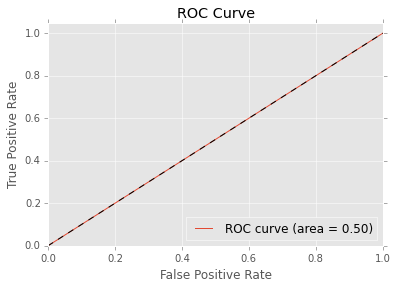

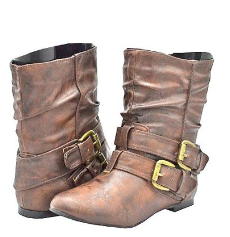

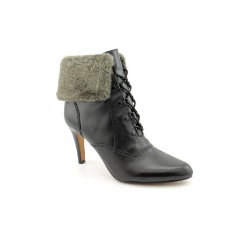

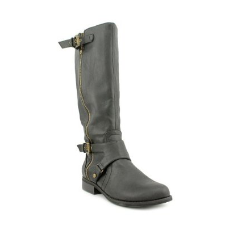

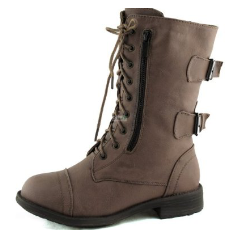

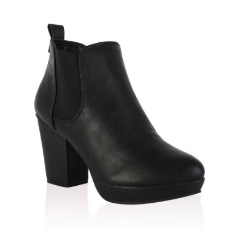

time: 3min 12s


In [20]:
param_grid = {"max_depth": [3, 4000],
              "max_features": np.arange(1,4000,200),
              "min_samples_split": np.arange(1,500,100),
              "min_samples_leaf": [100, 50, 25, 10, 5],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}
rf = TrainModel(training_set.copy(), test_set.copy(),
                   'rf', param_grid, 10)
rf.get_auc()
rf.report()
rf.plot_roc()

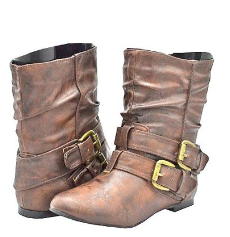

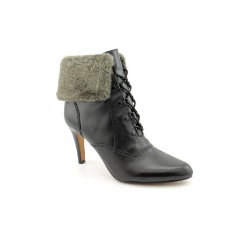

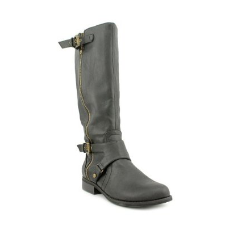

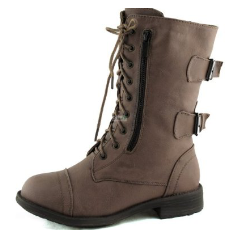

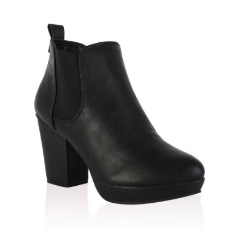

time: 572 ms


In [26]:
rf.model.fit(training_set.drop('like', axis = 1), training_set.like)
rf.display_recommendations(unlabeled.copy(), 10)

### Elastic Net logistic regression

SGDClassifier(alpha=9.9999999999993463, average=False, class_weight=None,
       epsilon=0.1, eta0=0.0, fit_intercept=True, l1_ratio=1.0,
       learning_rate='optimal', loss='squared_loss', n_iter=5, n_jobs=1,
       penalty='elasticnet', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
Model with rank: 1
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 9.9999999999993463, 'l1_ratio': 1.0}

Model with rank: 2
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 12.589254117940838, 'l1_ratio': 1.0}

Model with rank: 3
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 15.848931924610072, 'l1_ratio': 0.80000000000000004}



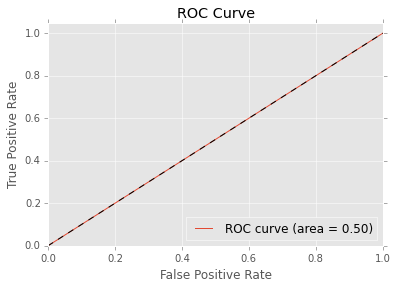

time: 1min 37s


In [33]:
param_grid = [
        {'alpha': [10**i for i in np.arange(-7,2,.1)], 
         'l1_ratio': np.arange(0,1.1,0.1)
        }]

enet = TrainModel(training_set.copy(), test_set.copy(),
                   'lr_enet', param_grid, 2)
enet.get_auc()
enet.report()
enet.plot_roc()

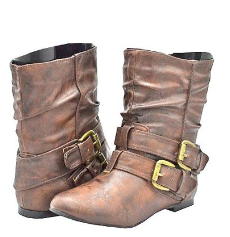

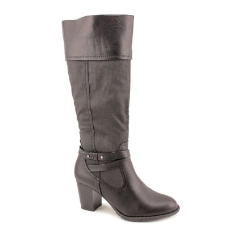

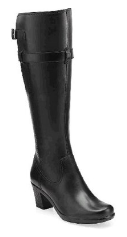

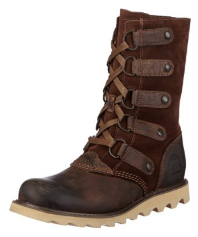

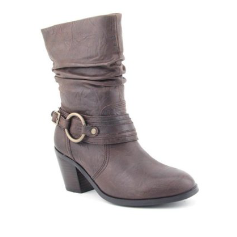

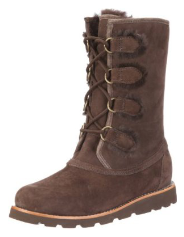

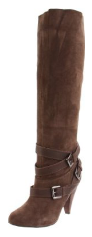

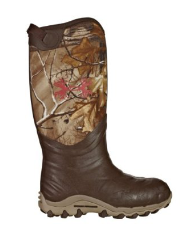

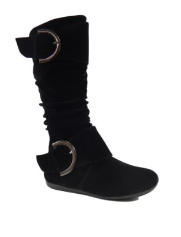

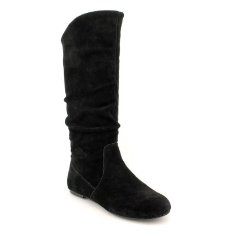

time: 1.38 s


In [28]:
enet.model.fit(training_set.drop('like', axis = 1), training_set.like)
enet.display_recommendations(unlabeled.copy(), 10)

### Scikit-learn SGD Classifier

Model with rank: 1
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 9.9999999999999995e-08, 'l1_ratio': 0.0, 'loss': 'hinge', 'class_weight': {0: 0.25, 1: 0.75}}

Model with rank: 2
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 9.9999999999999995e-08, 'l1_ratio': 0.0, 'loss': 'log', 'class_weight': {0: 0.25, 1: 0.75}}

Model with rank: 3
Mean validation score: 0.975 (std: 0.029)
Parameters: {'alpha': 9.9999999999999995e-08, 'l1_ratio': 0.0, 'loss': 'modified_huber', 'class_weight': {0: 0.25, 1: 0.75}}



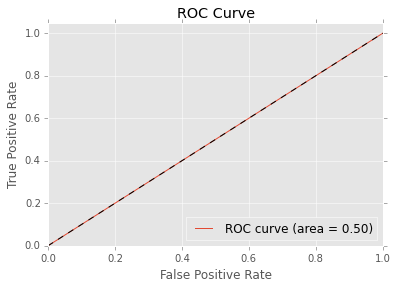

time: 18min 56s


In [31]:
param_grid = [
        {'alpha': [10**i for i in np.arange(-7,2,.1)], 
         'l1_ratio': np.arange(0,1.1,0.1),
         'loss': ['squared_loss', 'hinge', 'log', 'modified_huber', 'squared_hinge', 'perceptron'],
         'class_weight': [{1: 0.75, 0: 0.25}, {1: 0.90, 0: 0.10}, {1: 0.50, 0: 0.50}]
        }]

sgd = TrainModel(training_set.copy(), test_set.copy(),
                   'sgd', param_grid, 2)
sgd.get_auc()
sgd.report()
sgd.plot_roc()

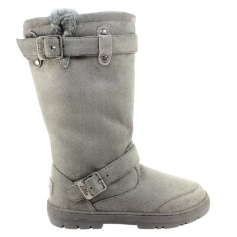

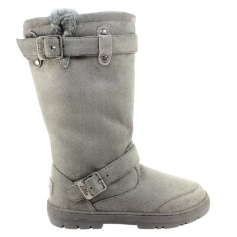

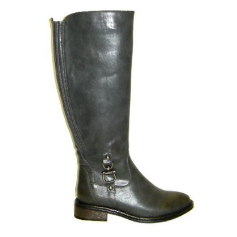

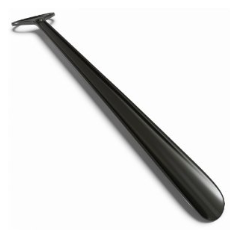

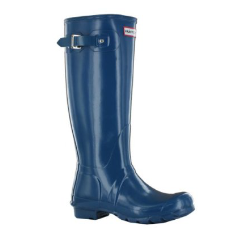

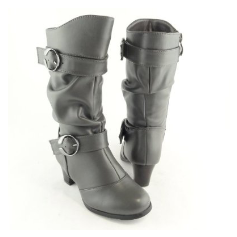

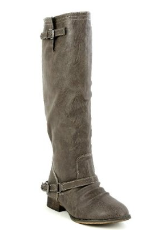

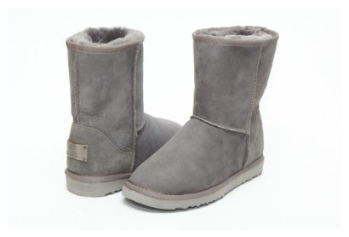

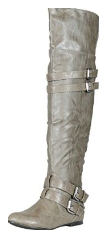

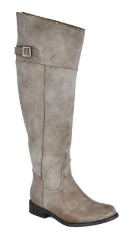

time: 2.16 s


In [32]:
sgd.model.fit(training_set.drop('like', axis = 1), training_set.like)
sgd.display_recommendations(unlabeled.copy(), 10)